In [1]:
pip install imblearn xgboost

Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import numpy as np
import boto3
import io
from sklearn.feature_selection import  SelectKBest, f_classif
import matplotlib.pyplot as plt 
import seaborn as sns
from imblearn import under_sampling,over_sampling
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.preprocessing  import power_transform, StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression, SGDRegressor,Ridge, Lasso
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score,classification_report, confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
import pickle
import warnings
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (/opt/conda/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

In [3]:
%matplotlib inline

In [4]:
# Set up AWS credentials and create S3 client
session = boto3.Session(
aws_access_key_id='minioadmin',
aws_secret_access_key='minioadmin',
)
s3 = session.client('s3',endpoint_url='https://home.hpe-staging-ezaf.com:31900',verify=False)
from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')

# TODO: Delete code line below
today = "2023-07-11"

# Specify bucket name and folder path
bucket_name = 'bank'
folder_path = f'merged_data{today}'

# List objects in the folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)
print(response)
file_objects = response['Contents']

# Print the names of all files in the folder
print("Files in the folder:")
for file in file_objects:
    file_name = file['Key']
    print(file_name)
# Filter and select the CSV file in the folder
csv_files = [file for file in file_objects if file['Key'].lower().endswith('.csv')]

if len(csv_files) == 1:
    csv_file = csv_files[0]
    file_key = csv_file['Key']

# Download CSV file from S3 and load into DataFrame
csv_data = s3.get_object(Bucket=bucket_name, Key=file_key)['Body'].read().decode('utf-8')
df = pd.read_csv(io.StringIO(csv_data))
# Read the Dataset
# df = pd.read_csv("merged.csv")
df
df.head(25)
df.size
df.dtypes
df.shape
df.info()
df.columns

{'ResponseMetadata': {'RequestId': '177175D95879CE63', 'HostId': '', 'HTTPStatusCode': 200, 'HTTPHeaders': {'accept-ranges': 'bytes', 'content-length': '1046', 'content-security-policy': 'block-all-mixed-content', 'content-type': 'application/xml', 'server': 'MinIO', 'vary': 'Origin', 'x-amz-request-id': '177175D95879CE63', 'x-xss-protection': '1; mode=block', 'date': 'Thu, 13 Jul 2023 15:08:31 GMT'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Contents': [{'Key': 'merged_data2023-07-11/_SUCCESS', 'LastModified': datetime.datetime(2023, 7, 11, 5, 1, 8, 166000, tzinfo=tzlocal()), 'ETag': '"d41d8cd98f00b204e9800998ecf8427e"', 'Size': 0, 'StorageClass': 'STANDARD', 'Owner': {'DisplayName': 'minio', 'ID': '02d6176db174dc93cb1b899f7c6078f08654445fe8cf1b6ce98d8855f66bdbf4'}}, {'Key': 'merged_data2023-07-11/part-00000-3caa6459-6f1b-4a91-a522-5bdd770eb3e6-c000.csv', 'LastModified': datetime.datetime(2023, 7, 11, 5, 1, 8, 52000, tzinfo=tzlocal()), 'ETag': '"b7aab53158f588e5ad81753622fe0366"', '

Index(['age', 'job', 'marital', 'education', 'default1', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'target'],
      dtype='object')

<AxesSubplot:>

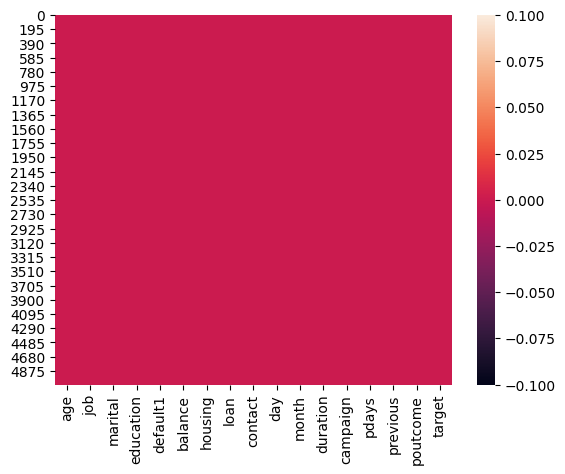

In [5]:
#checking Null Values in the dataset
df.isnull()

#checking the sum of the Dataset
df.isnull().sum()

#checking Null values by heatmap
sns.heatmap(df.isnull())

In [6]:
#checking any space in the dataset 

(df == ' ?')
(df == ' ?').sum()
#Or
(df == ' ').sum()
#checking any null value in the target column
df[df['target'] == '']
df[df['target'] == ''].index
df['target'].value_counts()
df['target'].unique()
df.nunique()

age            68
job            13
marital         3
education       4
default1        2
balance      2832
housing         2
loan            2
contact         3
day            31
month          12
duration     1272
campaign       50
pdays         542
previous       25
poutcome        4
target          2
dtype: int64

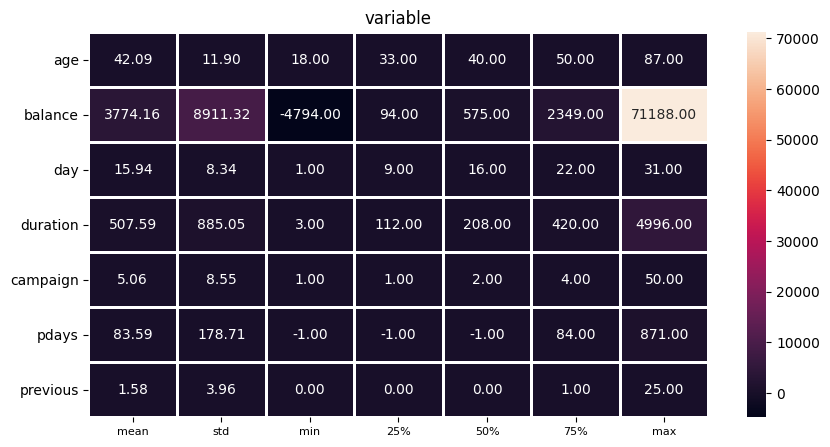

In [7]:
df.describe()
plt.figure(figsize=(10,5))
sns.heatmap(round(df.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt='.2f')
plt.xticks(fontsize=14)
plt.xticks(fontsize=8)
plt.title('variable')
plt.show()

no     4253
yes     808
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='Count'>

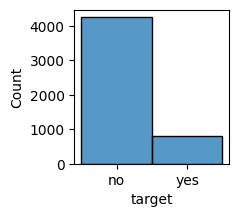

In [8]:
# Data Cleaning and Preprocessing
df['age'].value_counts()
df['age'].unique()
#Histplot for "tenure" column
print(df["target"].value_counts())
plt.figure(figsize=(2,2))
sns.histplot(x='target',data=df,bins=73)

<AxesSubplot:xlabel='target', ylabel='count'>

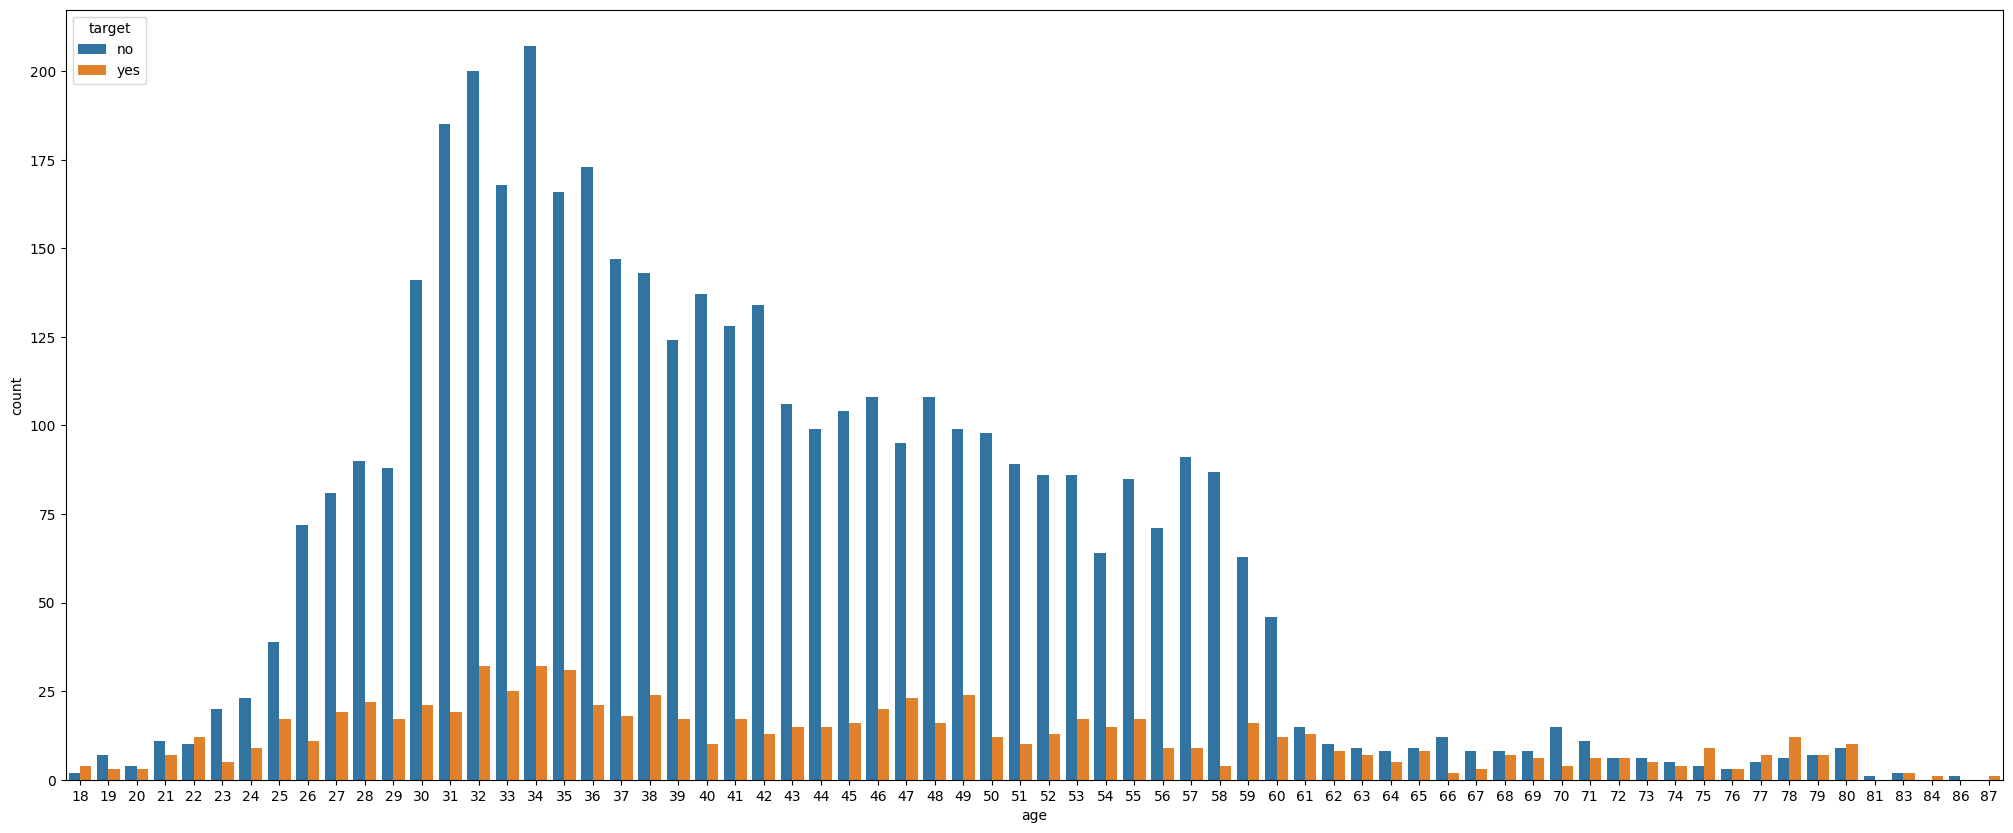

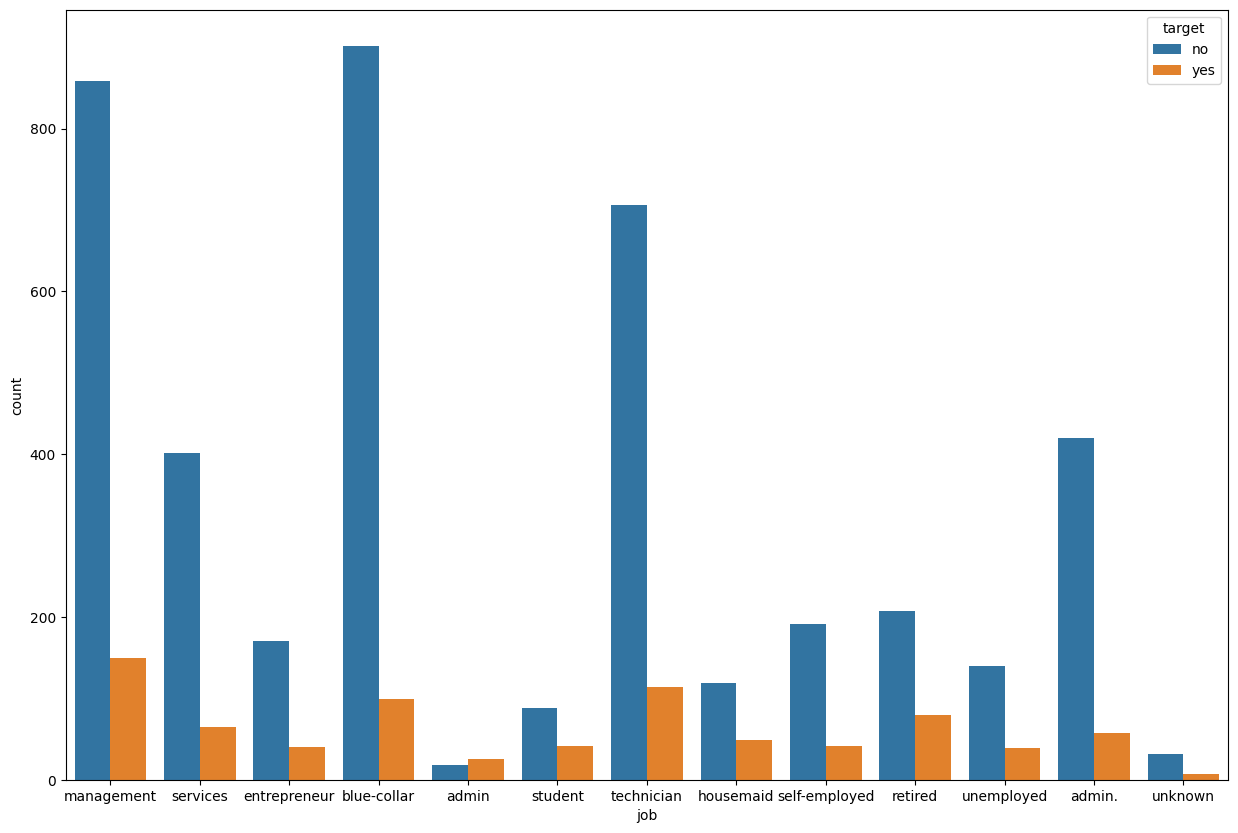

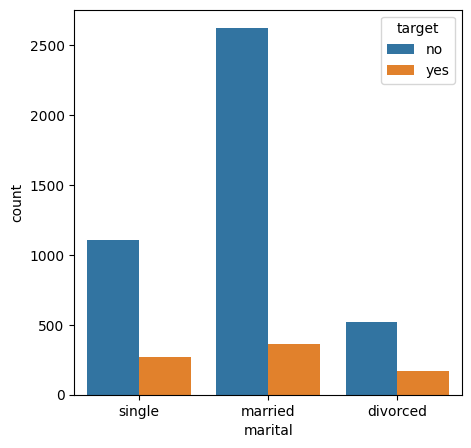

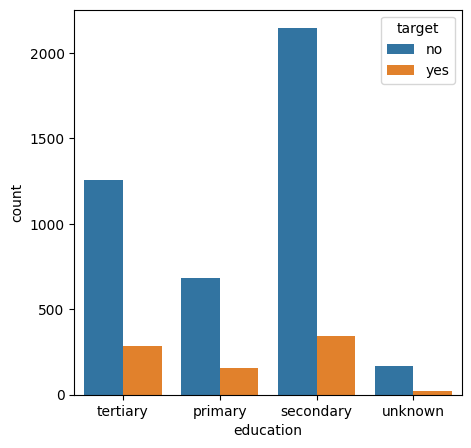

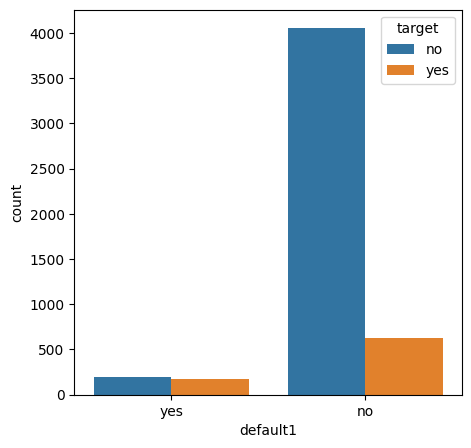

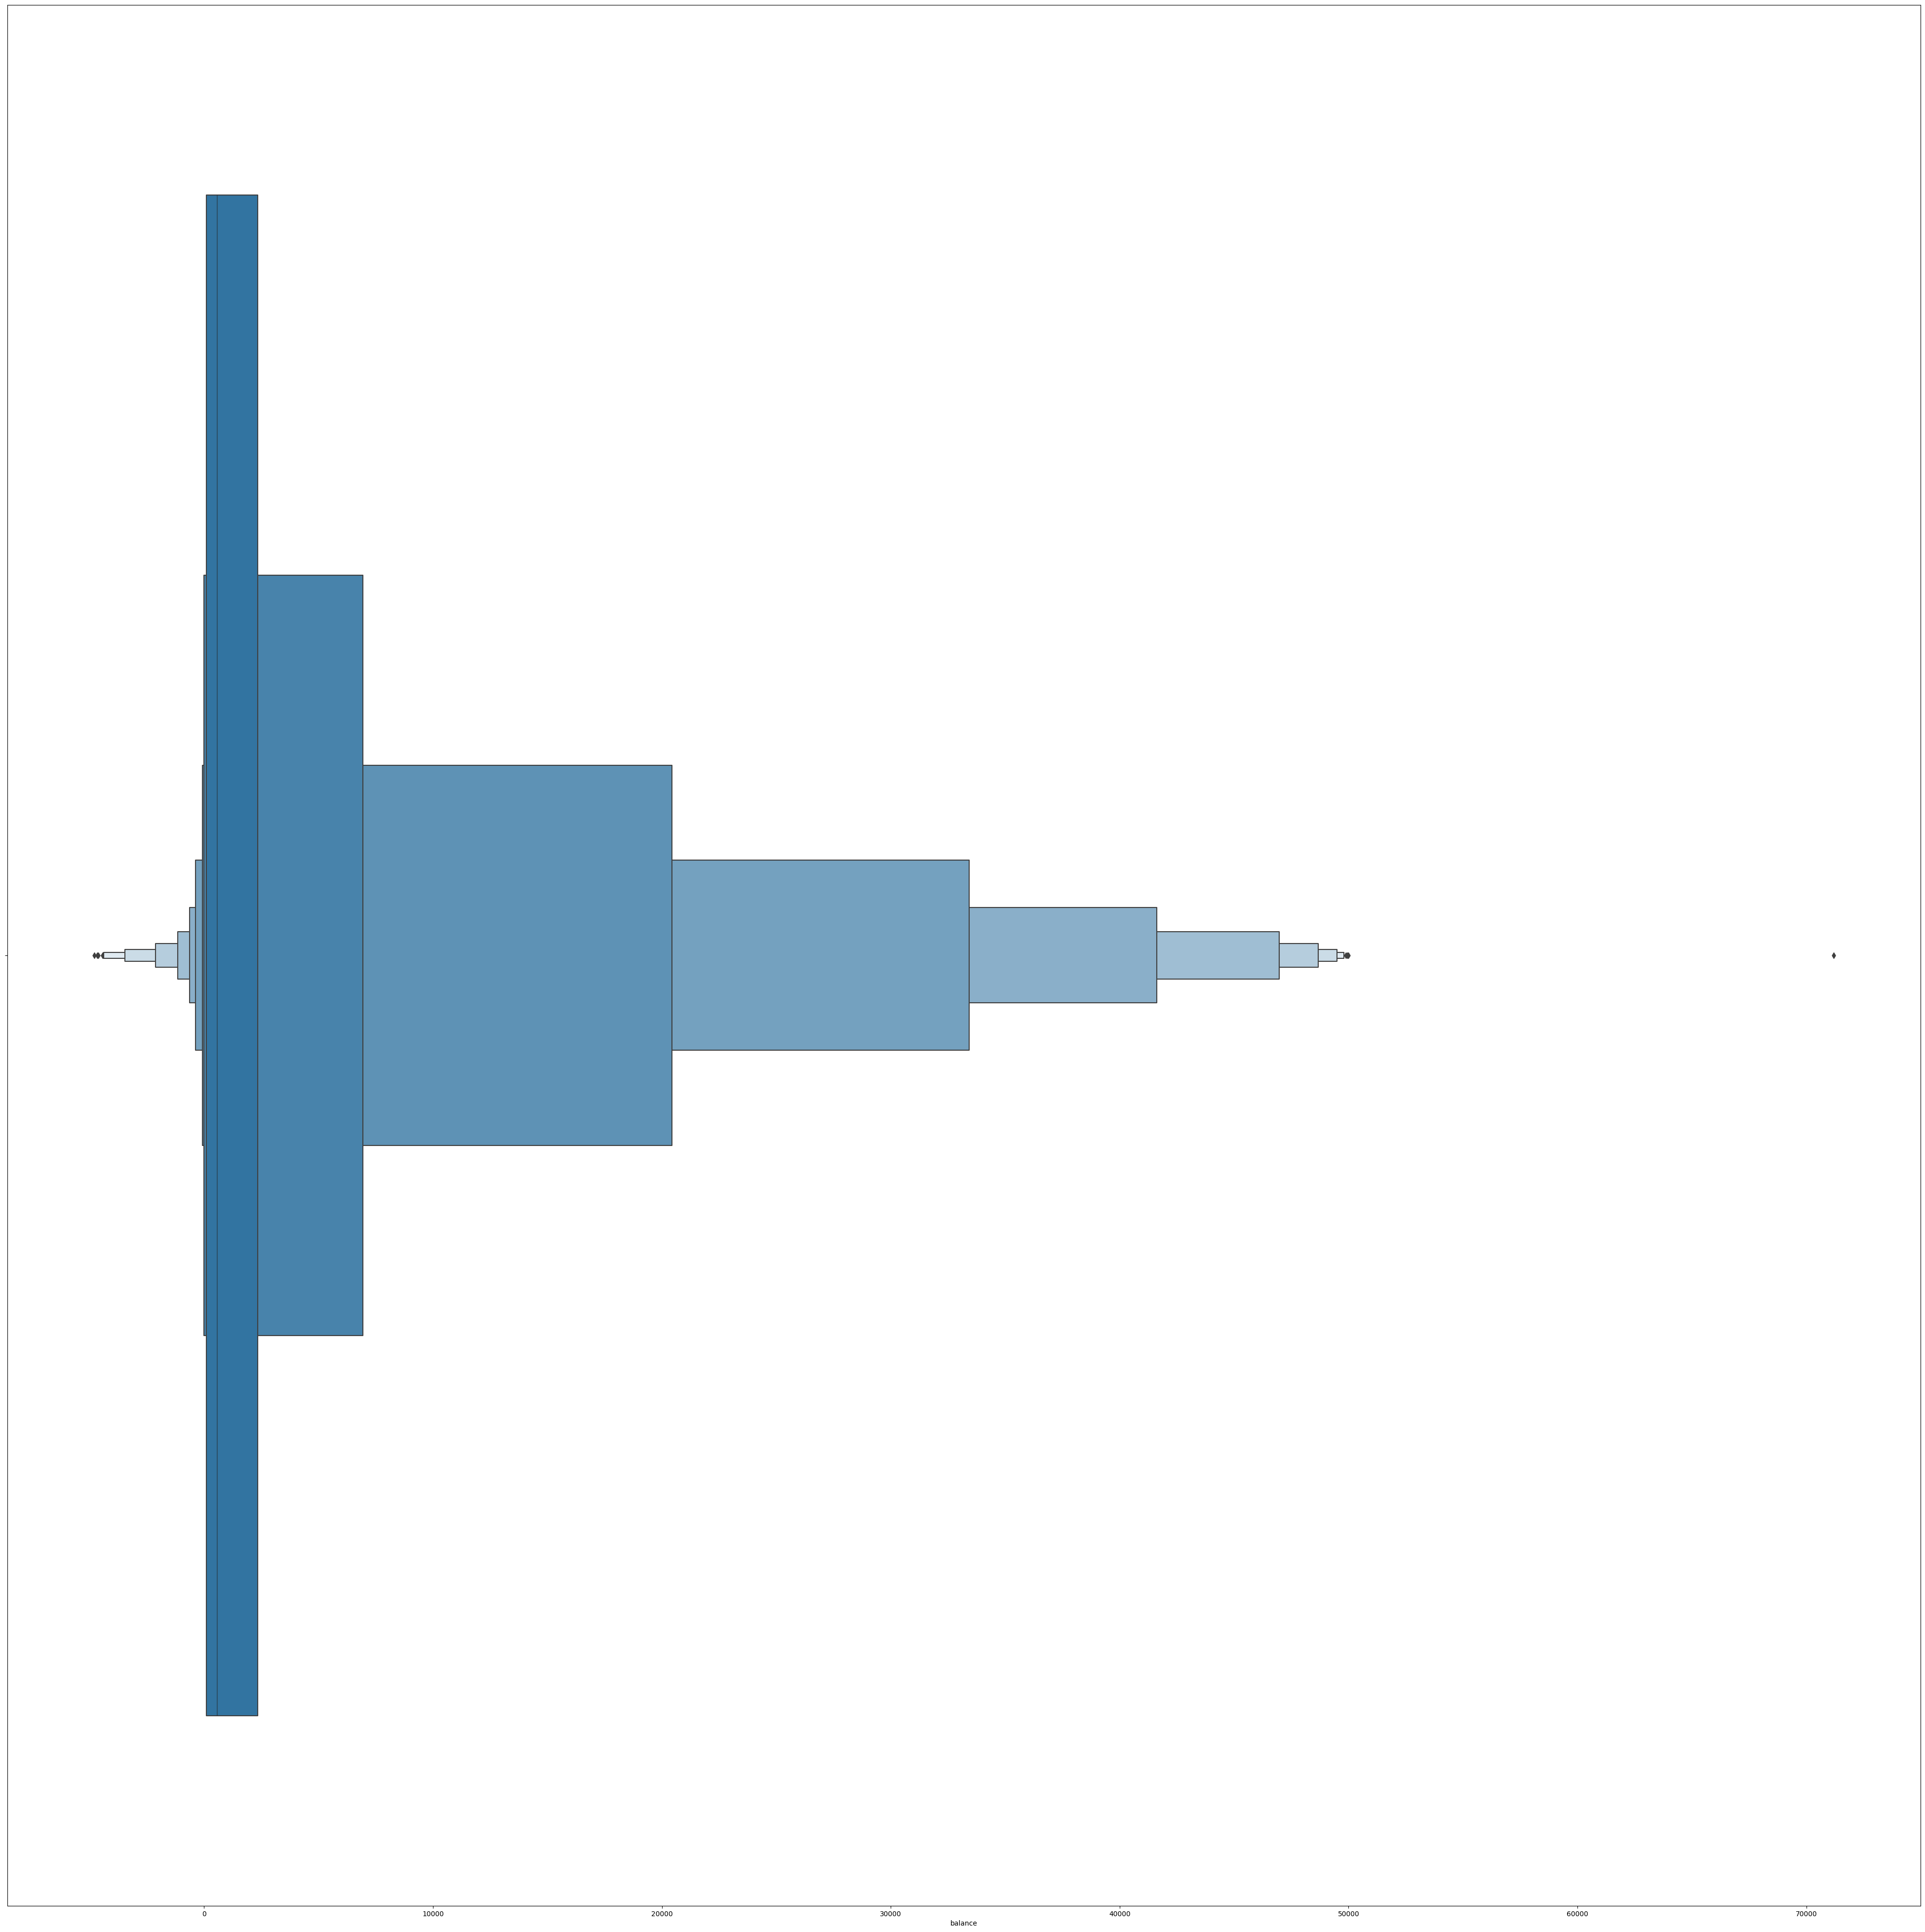

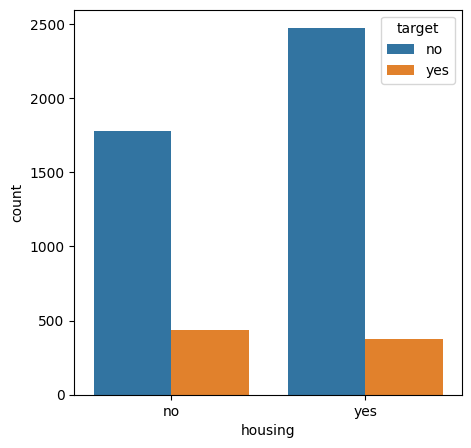

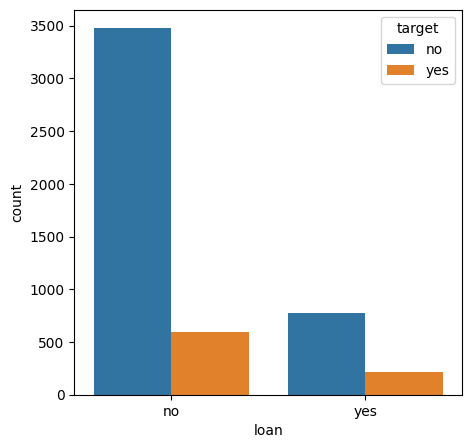

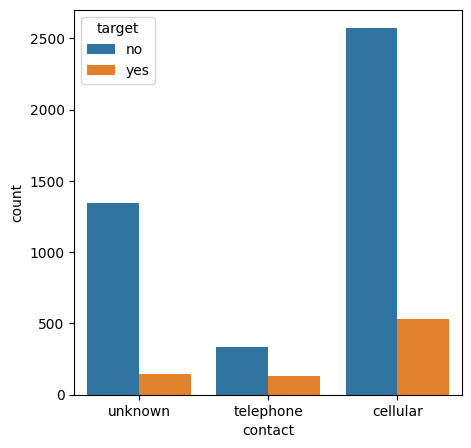

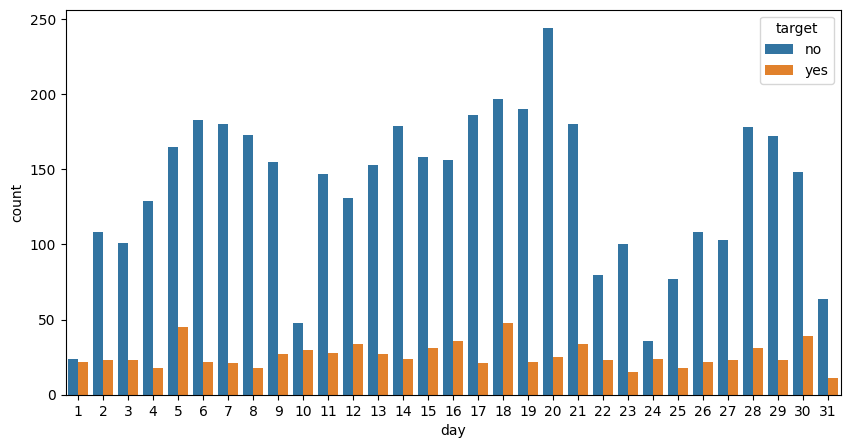

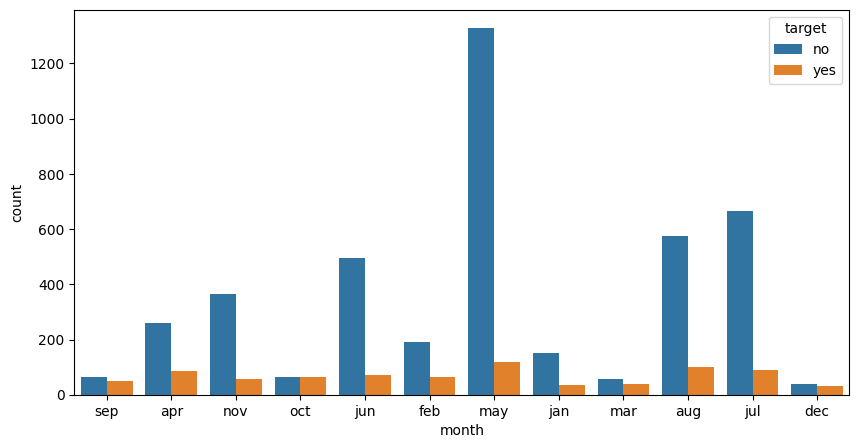

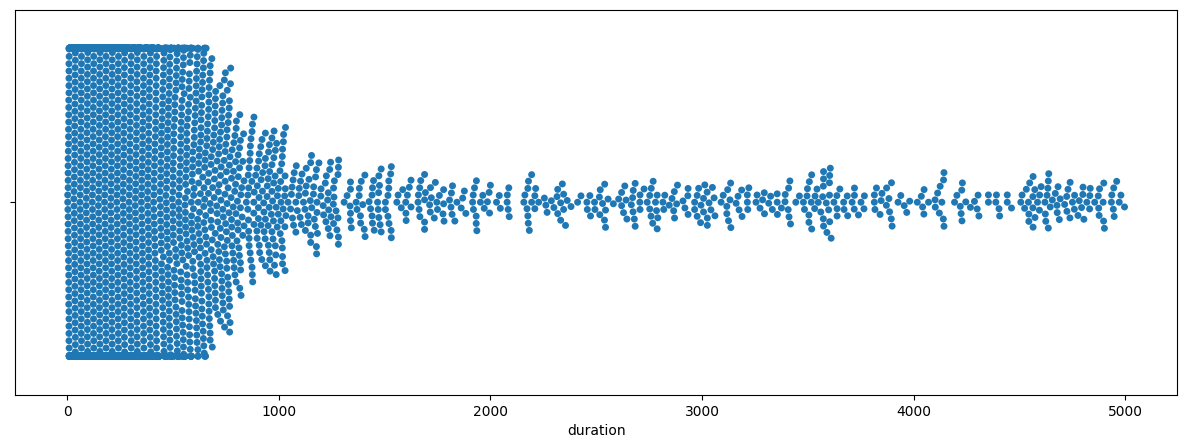

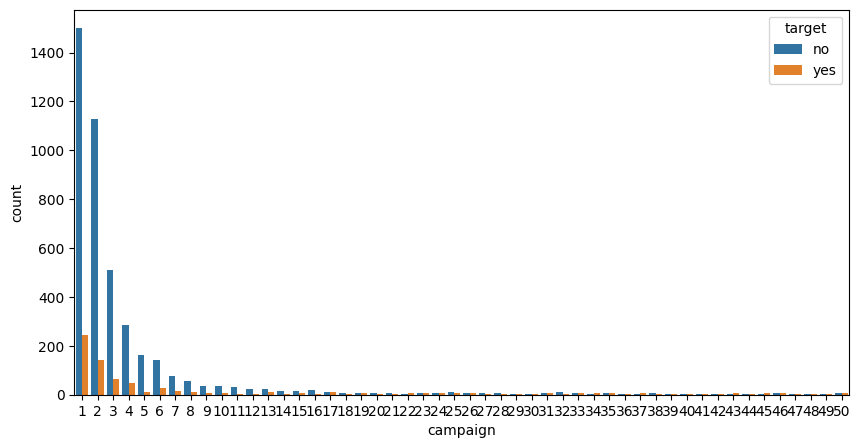

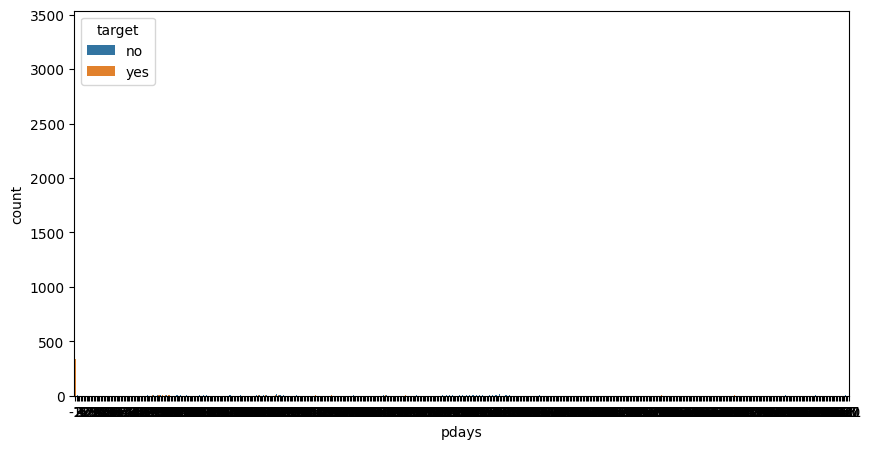

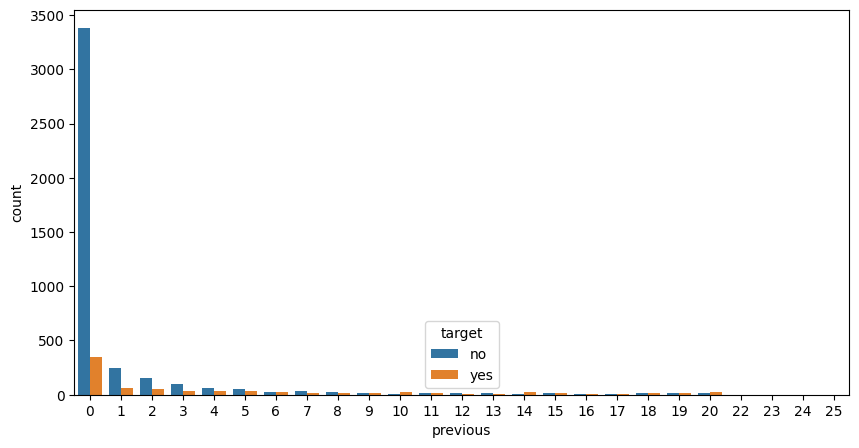

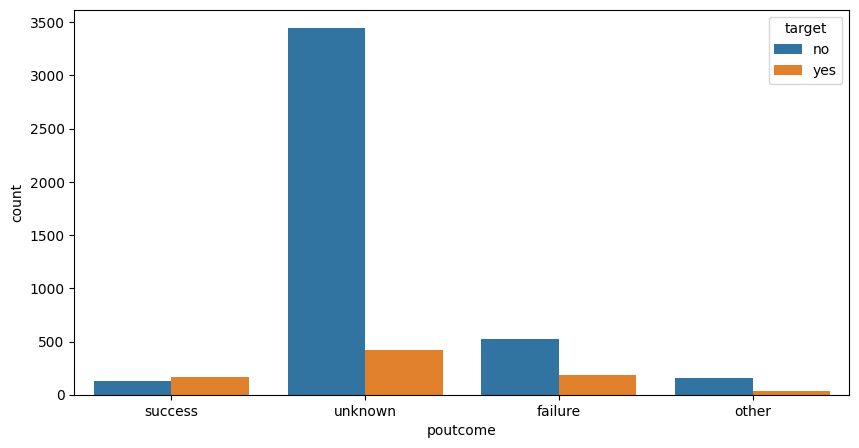

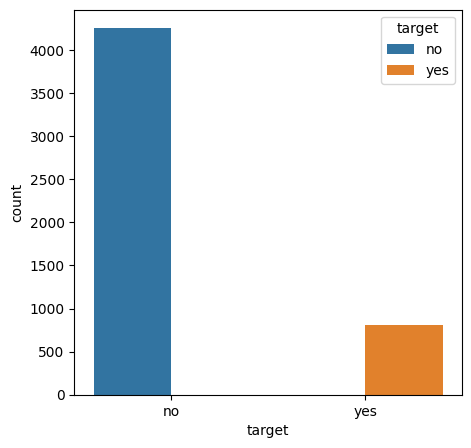

In [9]:
#  Bivariate Analysis
plt.figure(figsize=(25,10))
sns.countplot(x='age', data=df, hue='target')

plt.figure(figsize=(15,10))
sns.countplot(x='job', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='marital', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='education', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='default1', data=df,hue='target')

plt.figure(figsize=(50,50))
sns.boxenplot(x='balance', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='housing', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='loan', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='contact', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='day', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='month', data=df,hue='target')

plt.figure(figsize=(15,5))
sns.swarmplot(x='duration', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='campaign', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='pdays', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='previous', data=df,hue='target')

plt.figure(figsize=(10,5))
sns.countplot(x='poutcome', data=df,hue='target')

plt.figure(figsize=(5,5))
sns.countplot(x='target', data=df,hue='target')

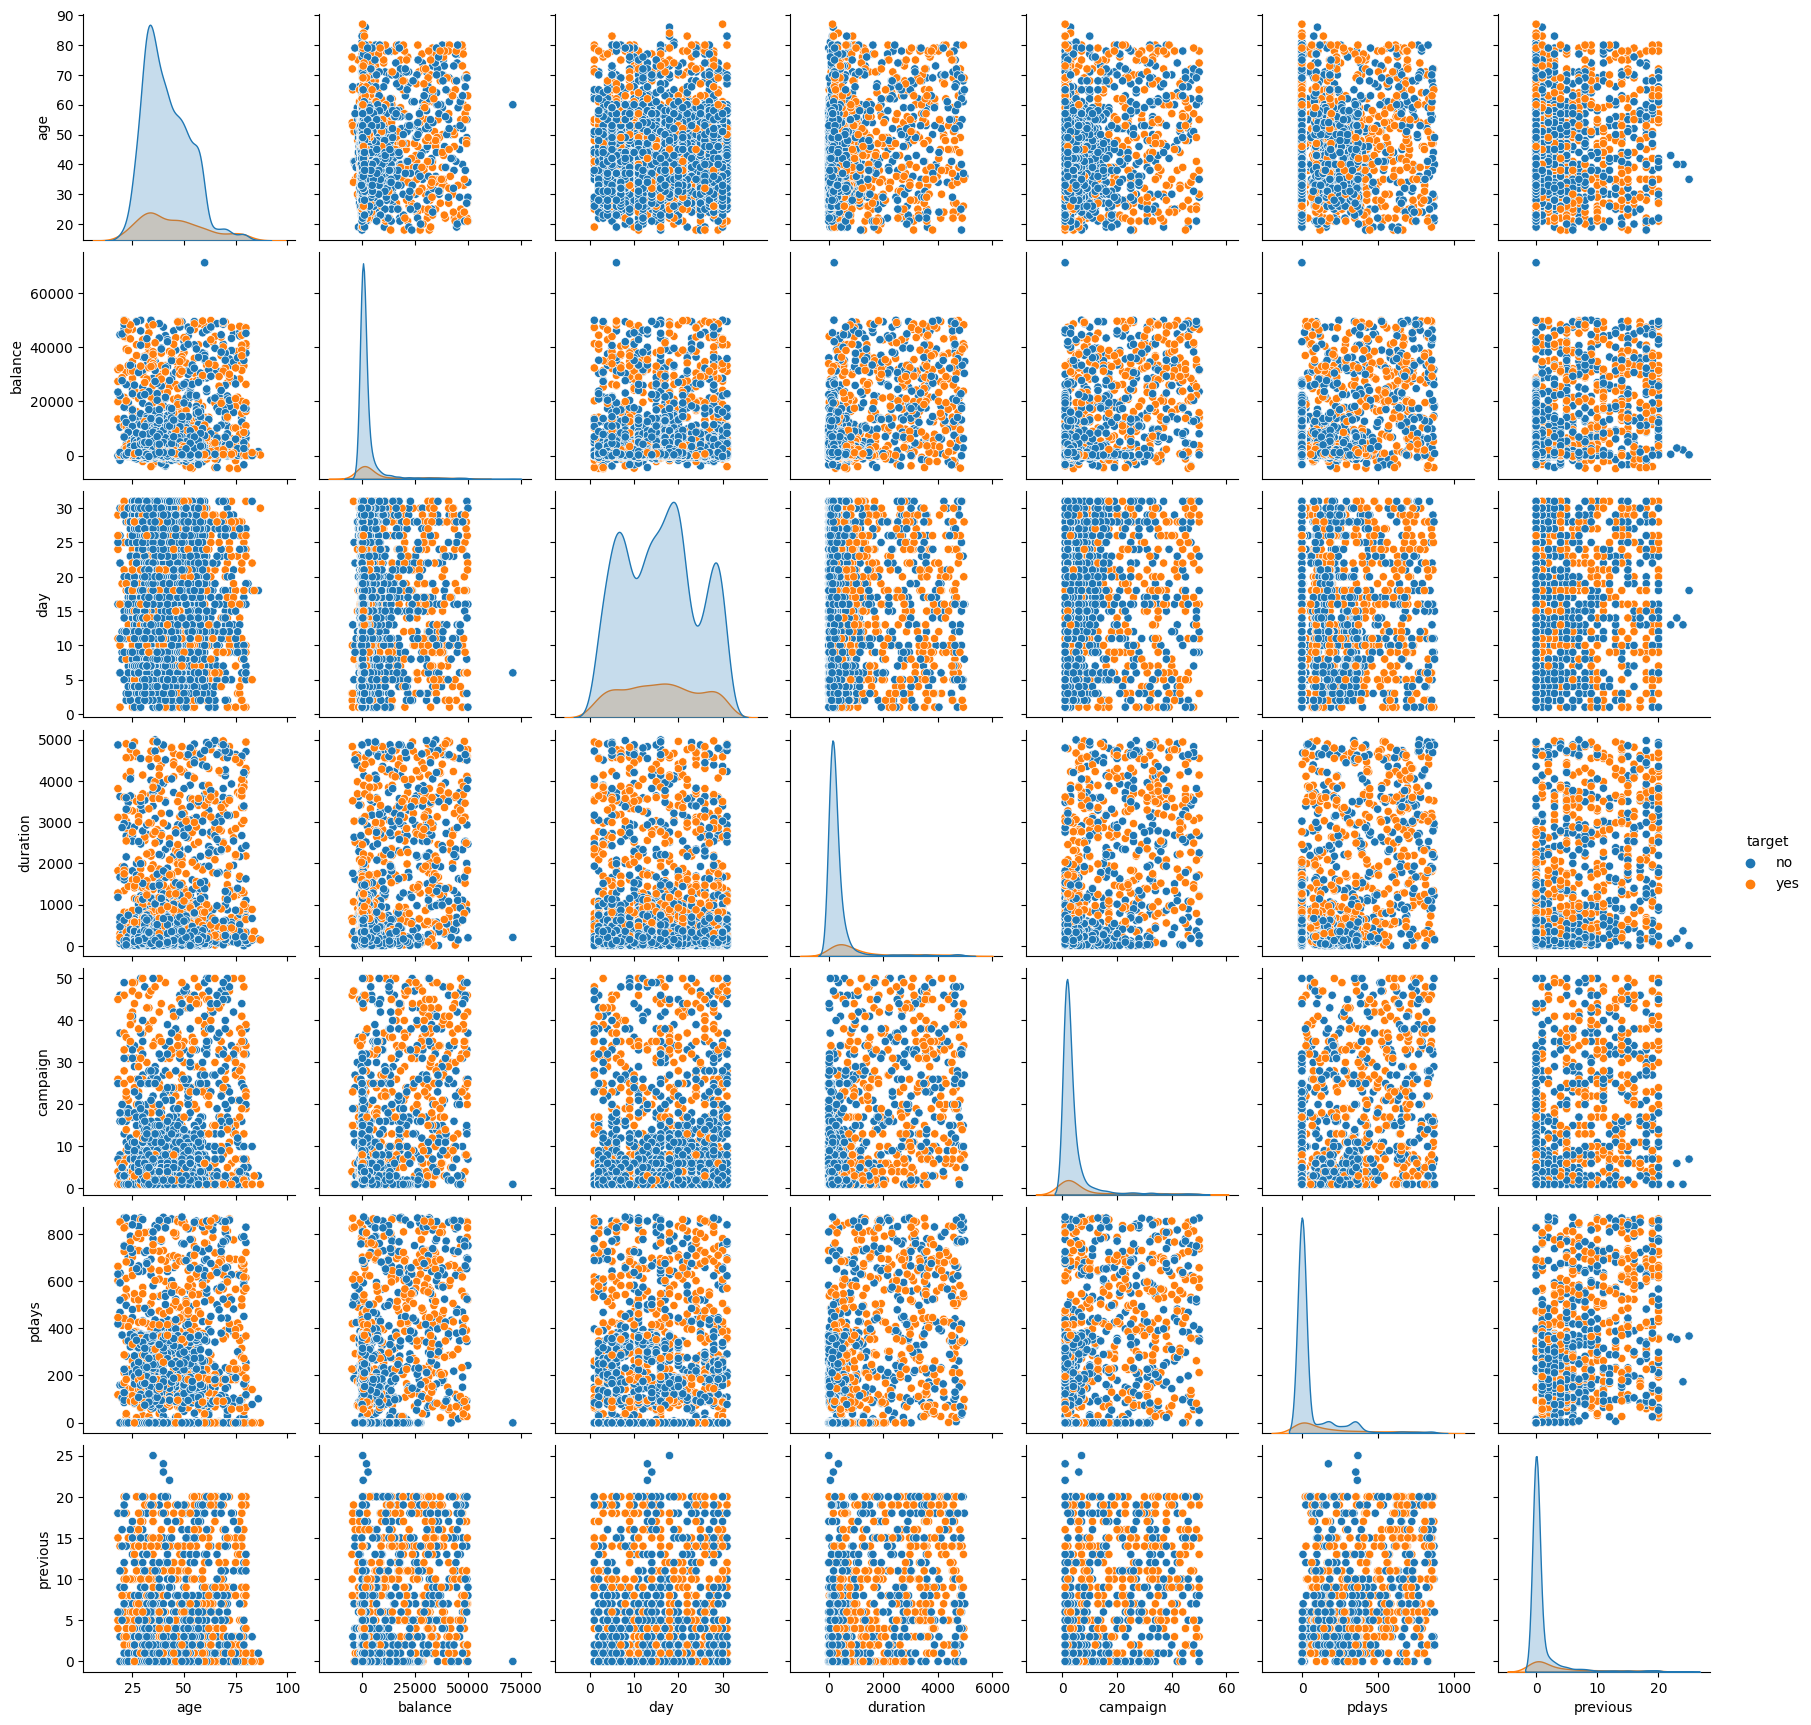

In [10]:
sns.pairplot(df,hue='target')

In [11]:
enc = LabelEncoder()
for i in df.columns:
    if df[i].dtypes =='object':
        df[i]=enc.fit_transform(df[i].values.reshape(-1,1))

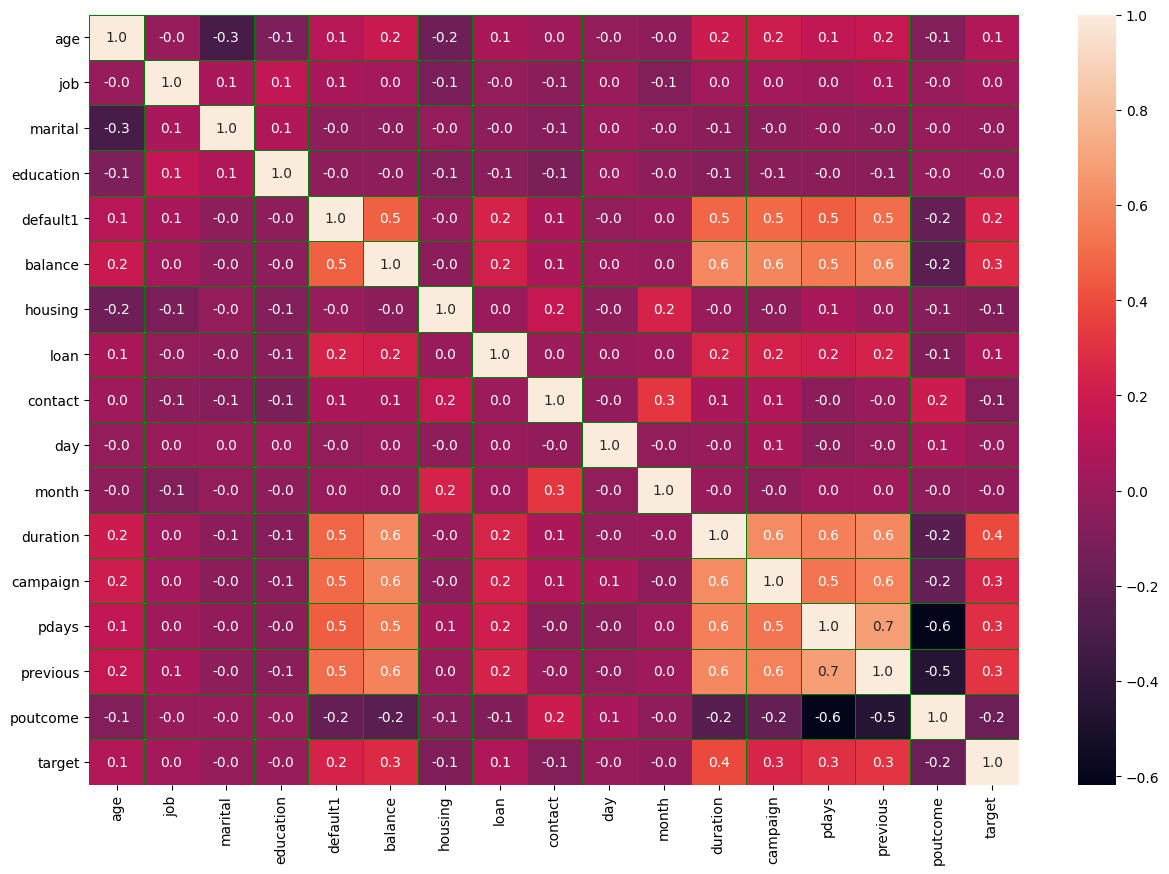

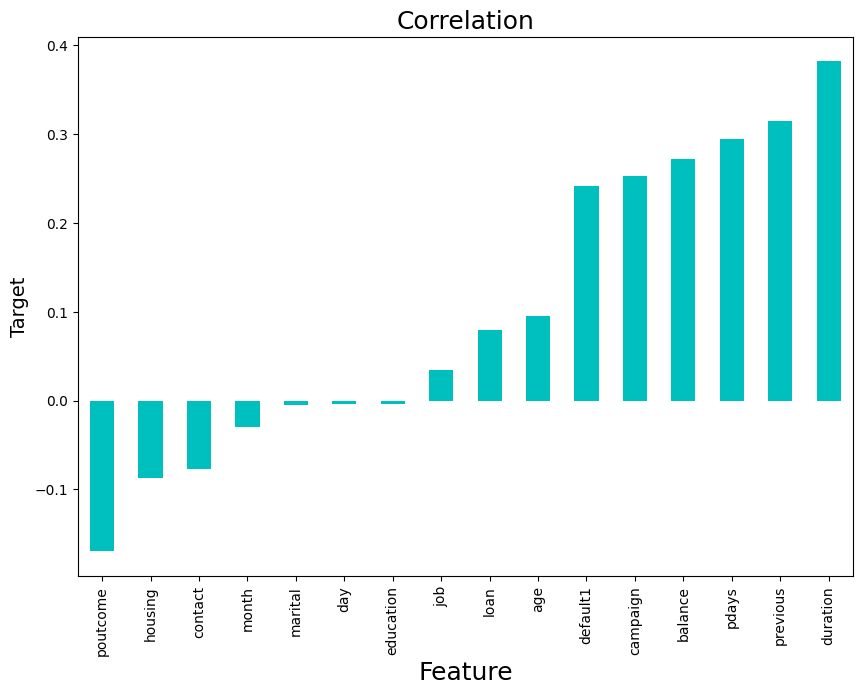

In [12]:
#  Checking Correlation
df.head(50)
df.corr()
df.corr()['target'].sort_values()

# Checking Correlation with Heatmap

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True, linewidths=0.5,linecolor='green',fmt='.1f')

#  Checking Correlation with barplot
plt.figure(figsize=(10,7))
df.corr()['target'].sort_values(ascending=True).drop(['target']).plot(kind='bar',color = 'c')
plt.xlabel('Feature',fontsize=18)
plt.ylabel('Target',fontsize=14)
plt.title('Correlation',fontsize = 18)
plt.show()

In [13]:
# We can observe :
# All columns are sorted in ascending order showing least to strong correlation with target column. 
# 13 columns are negatively correlated and 7 columns are positively correlated. Column 'MonthlyCharges' 
# is highly correlated with Target column 'Churn' and Column 'Contract' is least correlated with Target column 'Churn'.

age          0.766592
job          0.201359
marital     -0.106270
education    0.135743
default1     3.236636
balance      3.356140
housing     -0.252203
loan         1.530413
contact      0.669907
day          0.082110
month       -0.421256
duration     3.262007
campaign     3.280323
pdays        2.445342
previous     3.112438
poutcome    -1.627539
target       1.858937
dtype: float64

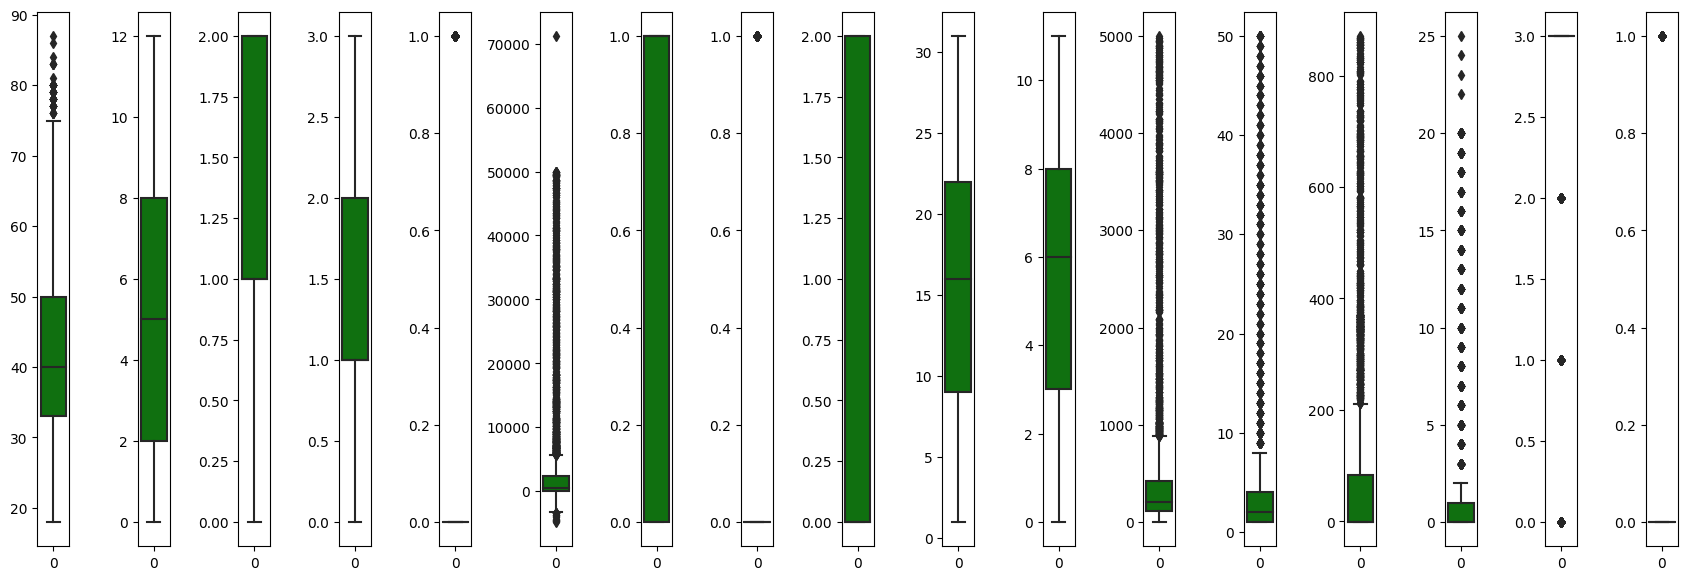

In [14]:
# Checking Outliers
collist=df.columns.values
ncol=21
nrows=11
plt.figure(figsize=(ncol,3*ncol))
for column in range(0,len(collist)):
    plt.subplot(nrows,ncol,column+1)
    sns.boxplot(data=df[collist[column]],color='green',orient='v')
  #  plt.xlabel(column,frontsize = 15)
    plt.tight_layout()
df.skew()

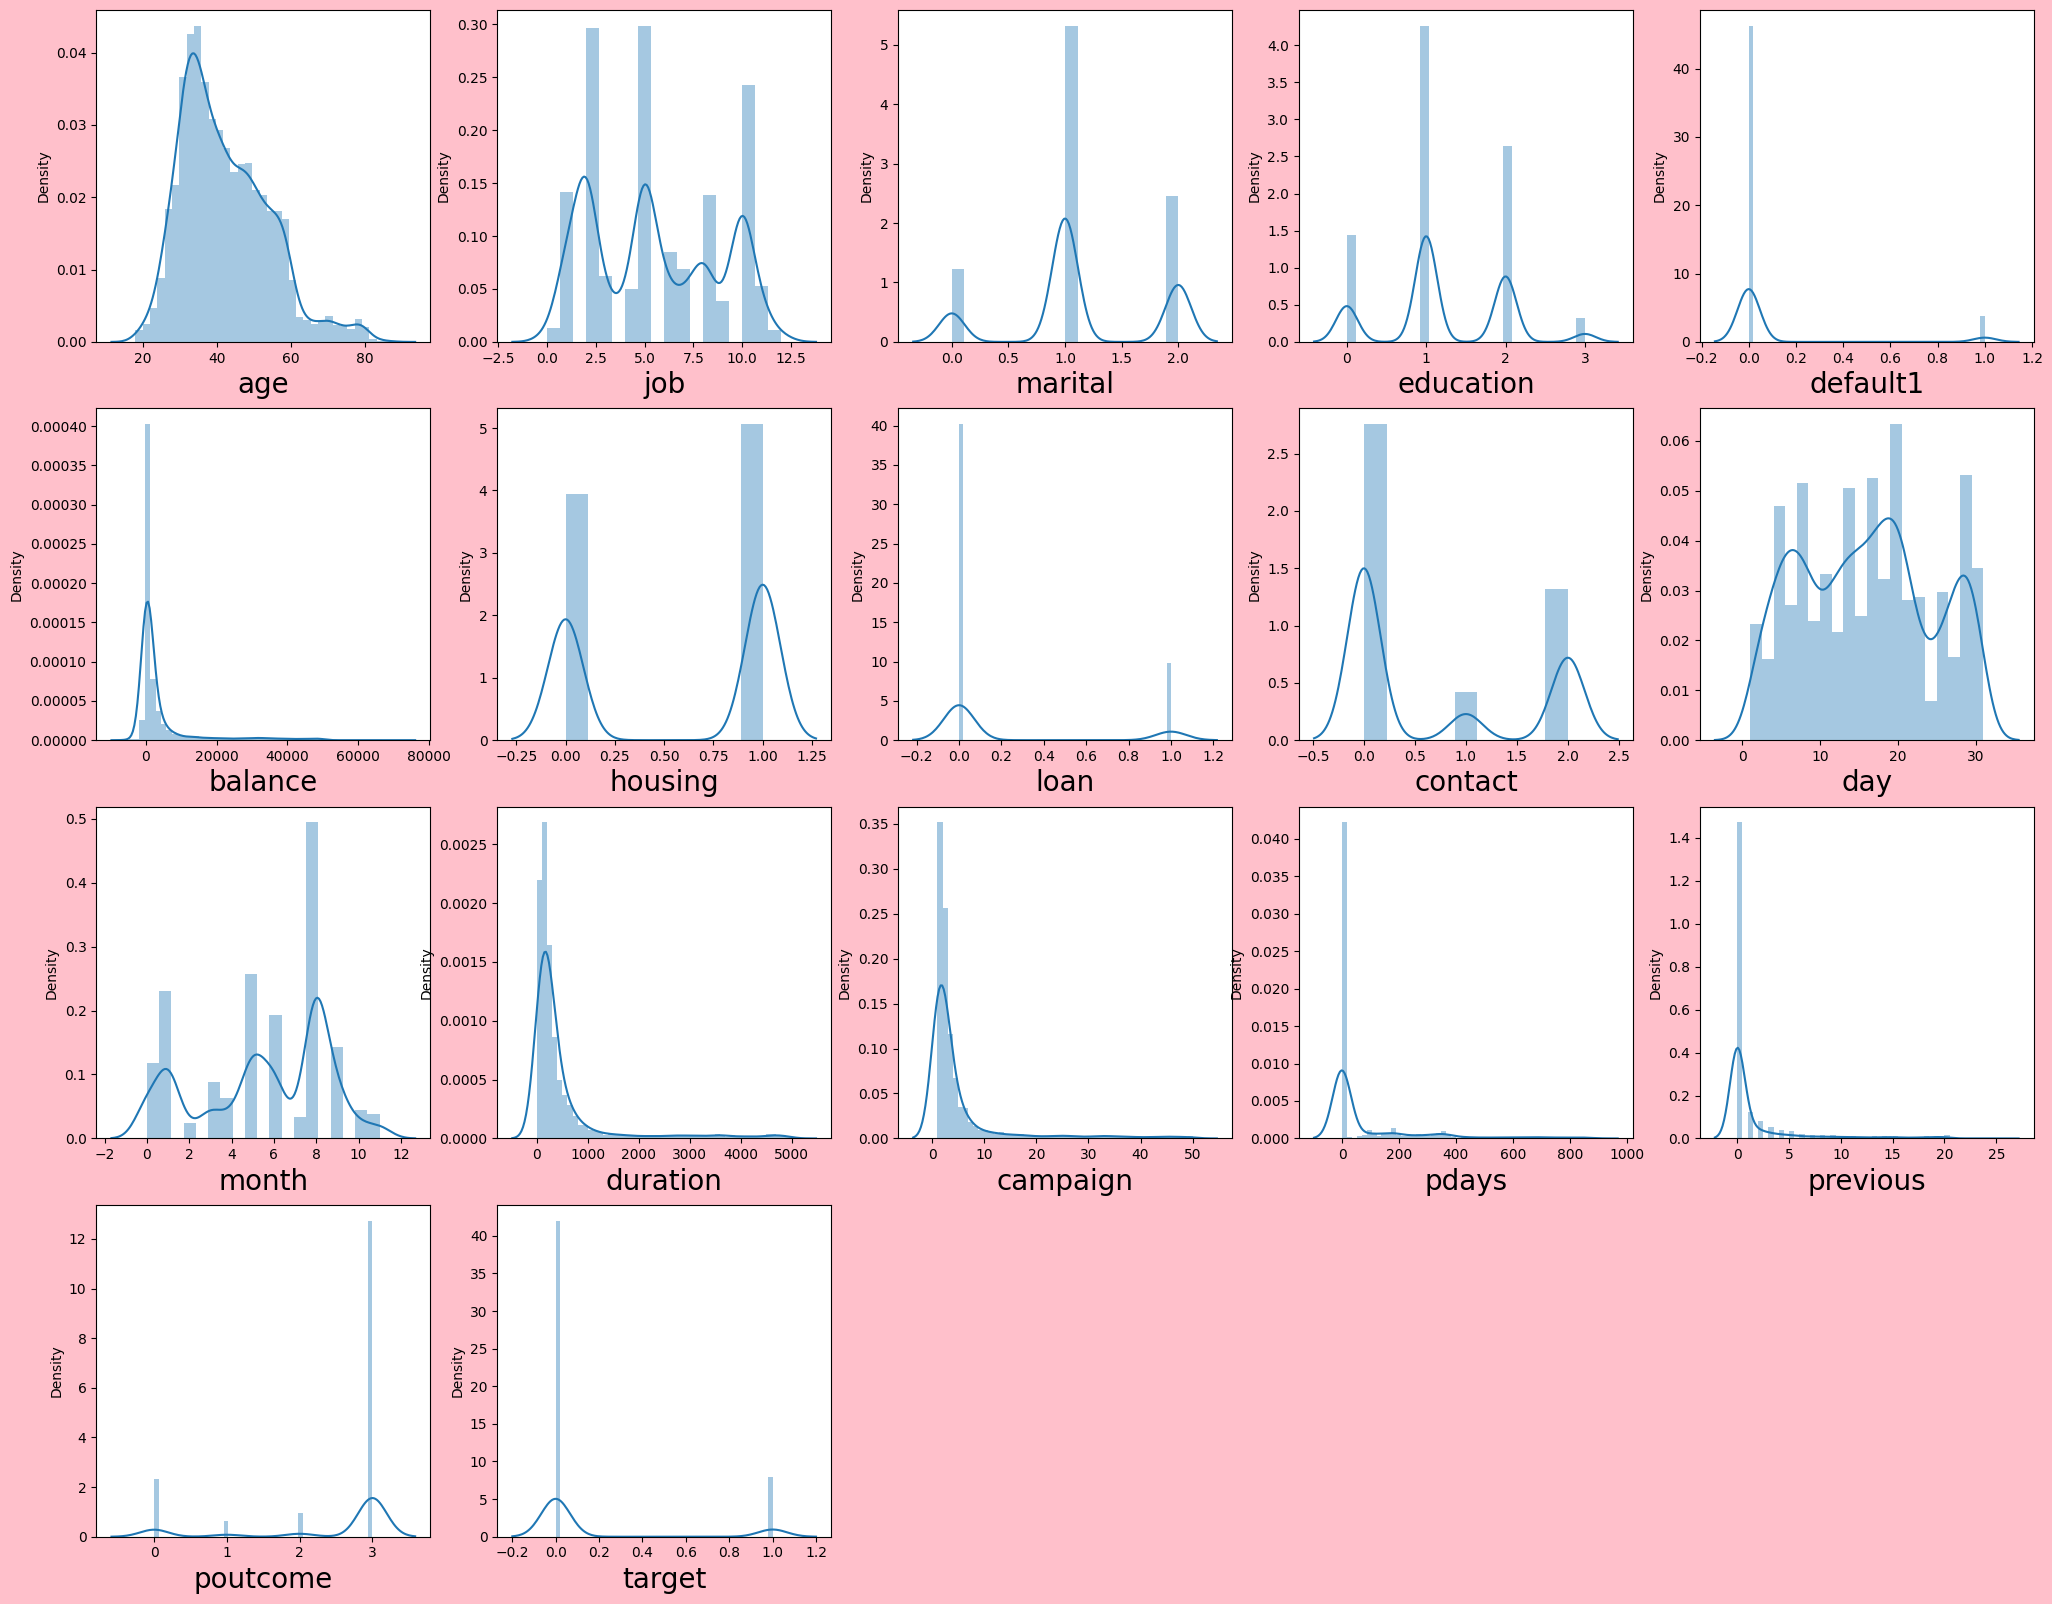

In [15]:
plt.figure(figsize=(25,25), facecolor='pink')
plotnumber = 1

for column in df:
    if plotnumber<=21:
        ax = plt.subplot(5,5,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

<AxesSubplot:xlabel='poutcome', ylabel='Density'>

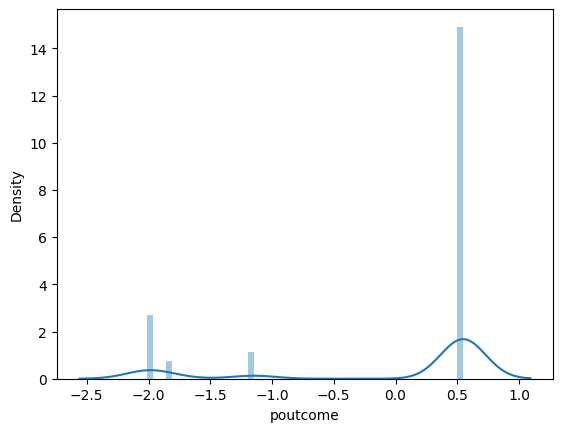

In [16]:
collist = ['poutcome']
df[collist]=power_transform(df[collist],method='yeo-johnson')
df[collist]
df.skew()
sns.distplot(df['poutcome'])

In [17]:
# Data Preprocessing
x=df.drop("target",axis=1)
y=df["target"]
x.columns
x.head(10)
y.head(10)
x.shape
y.shape
y.value_counts()
SM = SMOTE()
x, y = SM.fit_resample(x,y)
y.value_counts()

0    4253
1    4253
Name: target, dtype: int64

In [18]:
# Scaling data using Standard Scaler
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)
x.head()
x
var_threshold = VarianceThreshold(threshold=0)
var_threshold.fit(x)

var_threshold.get_support()
x.columns[var_threshold.get_support()]

# taking  out  all the  constant  columns 
cons_columns = [column for column in x.columns
               if column not in x.columns[var_threshold.get_support()]]
print(len(cons_columns))

0


In [19]:
# SelectKBest method
best_fit = SelectKBest(score_func = f_classif, k ='all')
fit = best_fit.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
fit = best_fit.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
dfcolumns.head()
featureScores = pd.concat([dfcolumns,dfscores],axis = 1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(12,'Score'))

      Feature        Score
11   duration  1597.590277
13      pdays  1035.856508
6     housing   990.763963
14   previous   967.749923
5     balance   729.998223
15   poutcome   708.855487
12   campaign   616.681171
8     contact   547.977090
2     marital   370.791956
3   education   301.684502
4    default1   210.533818
0         age    89.034298


In [20]:
# VIF(Variance Inflation factor)
vif = pd.DataFrame()
vif['VIF values'] = [variance_inflation_factor(x.values,i)for i in range(len(x.columns))]
vif['features'] = x.columns
vif


VIF values   features
0     1.163547        age
1     1.033755        job
2     1.112519    marital
3     1.084135  education
4     1.395185   default1
5     2.164638    balance
6     1.131715    housing
7     1.116006       loan
8     1.218298    contact
9     1.010864        day
10    1.136558      month
11    2.241927   duration
12    2.483760   campaign
13    3.213718      pdays
14    2.748428   previous
15    1.842298   poutcome

In [21]:
# Creating Model
maxAccu = 0
maxRS = 0
for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30, random_state =i)
    DTC = DecisionTreeClassifier()
    DTC.fit(x_train,y_train)
    pred = DTC.predict(x_test)
    acc = accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print('Best Accuracy is :- ', maxAccu, 'on Random State :- ',maxRS)

Best Accuracy is :-  0.8773510971786834 on Random State :-  62


In [22]:
# Creating train-test Split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.15,random_state=maxRS)
x.shape
y.shape
x_train.shape,y_train.shape, x_test.shape,y_test.shape

((7230, 16), (7230,), (1276, 16), (1276,))

Accuracy Score:-  0.8134796238244514
Confusion Matrix :- 
  [[518 121]
 [117 520]]
Classification Report :- 
                precision    recall  f1-score   support

           0       0.82      0.81      0.81       639
           1       0.81      0.82      0.81       637

    accuracy                           0.81      1276
   macro avg       0.81      0.81      0.81      1276
weighted avg       0.81      0.81      0.81      1276



Text(0.5, 1.0, 'Logistic Regressior Prediction Confusion Maxtrix ')

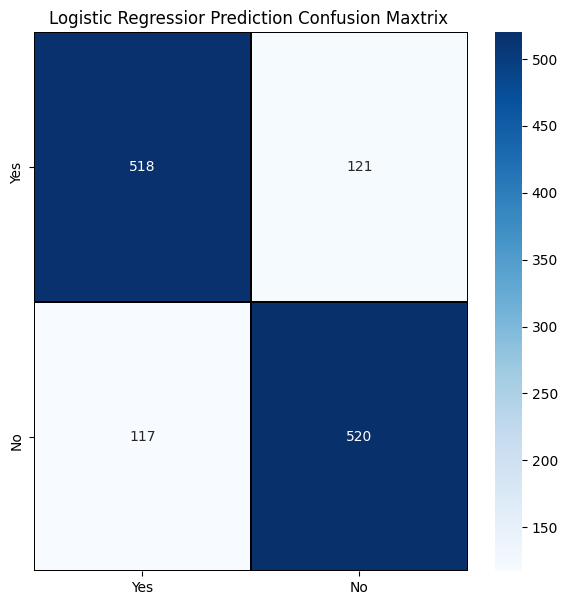

In [23]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train,y_train)
pred_lr = lr.predict(x_test)

print('Accuracy Score:- ', accuracy_score(y_test,pred_lr))

print('Confusion Matrix :- \n ', confusion_matrix(y_test,pred_lr))

print('Classification Report :- \n ',classification_report(y_test,pred_lr))

### Here we are getting 85% accuracy using Logistic Regression.
## Confusion Matrix for Logistic Regression

cm = confusion_matrix(y_test,pred_lr)
x_axis_labels = ['Yes', 'No']
y_axis_labels = ['Yes', 'No']
f,ax = plt.subplots(figsize = (7,7))
sns.heatmap(cm,annot = True, linewidths=.2,linecolor='black',fmt= '.0f',ax=ax, cmap = 'Blues',xticklabels=x_axis_labels,yticklabels=y_axis_labels)
plt.title('Logistic Regressior Prediction Confusion Maxtrix ')

Random Forest Accuracy Score is:- 
 
   0.9224137931034483

 Confusion Matrix is :-
   [[575  64]
 [ 35 602]]

 Classification Report is 
                 precision    recall  f1-score   support

           0       0.94      0.90      0.92       639
           1       0.90      0.95      0.92       637

    accuracy                           0.92      1276
   macro avg       0.92      0.92      0.92      1276
weighted avg       0.92      0.92      0.92      1276



Text(0.5, 1.0, 'RFC Prediction Confusion Matrix')

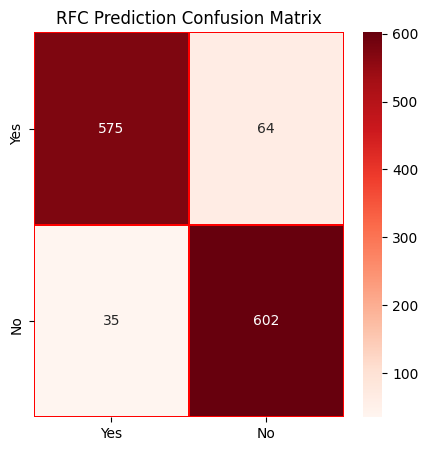

In [24]:
# Classification Algorithms 
## Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
pred_rfc = rfc.predict(x_test)

print('Random Forest Accuracy Score is:- \n \n  ',accuracy_score(y_test,pred_rfc))
print('\n Confusion Matrix is :-\n  ', confusion_matrix(y_test,pred_rfc))
print('\n Classification Report is \n  ', classification_report(y_test,pred_rfc))
## Confusion Matrix for Random Forest Classifier.
cm = confusion_matrix(y_test,pred_rfc)
x_axis_labels = ['Yes','No']
y_axis_labels = ['Yes','No']
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot=True,linewidths=.2,linecolor='red',fmt = '.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels=y_axis_labels)
plt.title ('RFC Prediction Confusion Matrix')


Decision Tree Classifier Accuracy Score is:- 
 
   0.8785266457680251

 Confusion Matrix is :-
   [[552  87]
 [ 68 569]]

 Classification Report is 
                 precision    recall  f1-score   support

           0       0.89      0.86      0.88       639
           1       0.87      0.89      0.88       637

    accuracy                           0.88      1276
   macro avg       0.88      0.88      0.88      1276
weighted avg       0.88      0.88      0.88      1276



Text(0.5, 1.0, 'DTC Prediction Confusion Matrix')

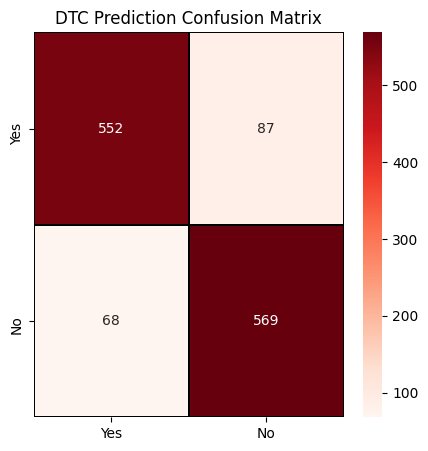

In [25]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
pred_dtc = dtc.predict(x_test)


print('Decision Tree Classifier Accuracy Score is:- \n \n  ',accuracy_score(y_test,pred_dtc))
print('\n Confusion Matrix is :-\n  ', confusion_matrix(y_test,pred_dtc))
print('\n Classification Report is \n  ', classification_report(y_test,pred_dtc))
## Confusion Matrix for Decision Tree Classifier.
cm = confusion_matrix(y_test,pred_dtc)
x_axis_labels = ['Yes','No']
y_axis_labels = ['Yes','No']
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot=True,linewidths=.2,linecolor='black',fmt='.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels = y_axis_labels)
plt.title('DTC Prediction Confusion Matrix')

Accuracy Score :-  0.8205329153605015
Confusion Matrix 
  [[513 126]
 [103 534]]
classification Report 
 :-                precision    recall  f1-score   support

           0       0.83      0.80      0.82       639
           1       0.81      0.84      0.82       637

    accuracy                           0.82      1276
   macro avg       0.82      0.82      0.82      1276
weighted avg       0.82      0.82      0.82      1276



Text(0.5, 1.0, 'SVM Classifier confusion_matrix')

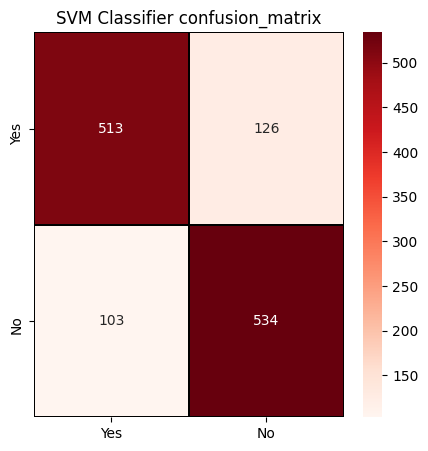

In [26]:
# Support Vector Machine Classifier
svc = SVC(kernel='linear',gamma='scale')
svc.fit(x_train,y_train)
pred_svc = svc.predict(x_test)

print('Accuracy Score :- ',accuracy_score(y_test,pred_svc))
print('Confusion Matrix \n ' ,confusion_matrix(y_test,pred_svc))
print('classification Report \n :- ',classification_report(y_test,pred_svc))
## Confusion Matrix for Support Vector Machine Classifier.
cm = confusion_matrix(y_test,pred_svc)
x_axis_labels = ['Yes','No']
y_axis_labels = ['Yes','No']
f,ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot=True,linewidths=.2,linecolor='black',fmt='.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels=y_axis_labels)
plt.title('SVM Classifier confusion_matrix')

In [27]:
# KNN Classifier
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
pred_knn=knn.predict(x_test)

print('Accuracy Score:- ',accuracy_score(y_test,pred_knn))
print('Confusion Matrix:- ',confusion_matrix(y_test,pred_knn))
print('Classifier Report:- ', classification_report(y_test,pred_knn))
## Confusion Matrix for KNN Classifier.

cm = confusion_matrix(y_test,pred_knn)
x_axis_labels = ['Yes','No']
y_axis_labels = ['Yes','No']
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(cm,annot=True,linewidths=.2,linecolor='black',fmt = '.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels = y_axis_labels)
plt.title('KNN Classifier confusion Matrix')

AttributeError: 'Flags' object has no attribute 'c_contiguous'

GBC Accuracy Score is :  0.9059561128526645
GBC Confusion Matrix 
 [[571  68]
 [ 52 585]]
GBC Classification report 
               precision    recall  f1-score   support

           0       0.92      0.89      0.90       639
           1       0.90      0.92      0.91       637

    accuracy                           0.91      1276
   macro avg       0.91      0.91      0.91      1276
weighted avg       0.91      0.91      0.91      1276



Text(0.5, 1.0, 'Confusion Matrix of GBC')

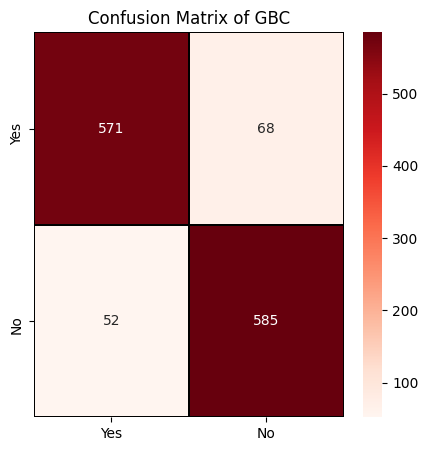

In [28]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.8,max_depth=4)
gbc.fit(x_train,y_train)
pred_gbc = gbc.predict(x_test)
print('GBC Accuracy Score is : ',accuracy_score(y_test,pred_gbc))
print('GBC Confusion Matrix \n',confusion_matrix(y_test,pred_gbc))
print('GBC Classification report \n',classification_report(y_test,pred_gbc))
## Confusion Matrix for Gradient Boosting Classifier.
cm = confusion_matrix(y_test,pred_gbc)
x_axis_labels = ['Yes','No']
y_axis_labels = ['Yes','No']
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot = True,linewidths=.2,linecolor='black',fmt='.0f',ax=ax,cmap='Reds',xticklabels = x_axis_labels,yticklabels = y_axis_labels)
plt.title('Confusion Matrix of GBC')

The Accuracy of XGBC is:  0.9177115987460815
Confusion Matrix of XGBC :- 
  [[577  62]
 [ 43 594]]
classification report of XGBC:- 
                precision    recall  f1-score   support

           0       0.93      0.90      0.92       639
           1       0.91      0.93      0.92       637

    accuracy                           0.92      1276
   macro avg       0.92      0.92      0.92      1276
weighted avg       0.92      0.92      0.92      1276



Text(0.5, 1.0, 'XGB Classifier prediction Confusion_matrix')

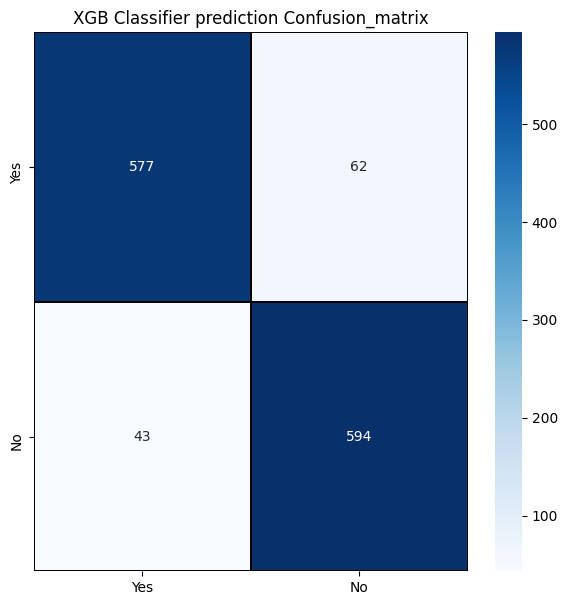

In [29]:
# XGB Classifier
XGBC= XGBClassifier()
XGBC.fit(x_train,y_train)
pred_XGBC = XGBC.predict(x_test)
print('The Accuracy of XGBC is: ',accuracy_score(y_test,pred_XGBC))
print('Confusion Matrix of XGBC :- \n ', confusion_matrix(y_test,pred_XGBC))
print('classification report of XGBC:- \n ', classification_report(y_test,pred_XGBC))
## Confusion Matrix for XGB Classifier.
cm = confusion_matrix(y_test,pred_XGBC)
x_axis_labels = ["Yes","No"]
y_axis_labels = ["Yes","No"]

f , ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, annot = True,linewidths=.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", 
xticklabels=x_axis_labels,
yticklabels=y_axis_labels)
plt.title("XGB Classifier prediction Confusion_matrix")

In [30]:
# Cross Validation Score for all the model
#    CV Score for Logistic Regrassion 
print('CV Score for logistic Regression :- ',cross_val_score(lr,x,y,cv=5).mean())

#    CV Score for Random Forest Classifier

print('CV Score for Random Forest Classifier: ',cross_val_score(rfc,x,y,cv=5).mean())

#    CV Score for Decision tree Classifier

print('CV score for Decision Tree Classifier',cross_val_score(dtc,x,y,cv=5).mean())


#    CV Score for support vector Classifire

print('CV Score for Support Vector Classifier ',cross_val_score(svc,x,y,cv=5).mean())

#  CV Score for KNN classifier

print('CV Score for KNN Classifier',cross_val_score(knn,x,y,cv=5).mean())

#    CV Score for Gradian boosting Classifier

print('CV Score for Gradian Boosting Classifier',cross_val_score(gbc,x,y,cv=5).mean())

#   CV score for XGB Classifier

print('CV Score for XGB Classifier',cross_val_score(XGBC,x,y,cv=5).mean())

CV Score for logistic Regression :-  0.8061530819984926
CV Score for Random Forest Classifier:  0.9039730551807846
CV score for Decision Tree Classifier 0.8587070852771335
CV Score for Support Vector Classifier  0.8092092782914039
CV Score for KNN Classifier nan
CV Score for Gradian Boosting Classifier 0.8945695868401182
CV Score for XGB Classifier 0.9033868927588733


In [33]:
### From the observation of accuracy and cross validation score and their difference we can predict that Random Forest Classifier is the best model.
disp = plot_roc_curve(lr,x_test,y_test)
plot_roc_curve(rfc,x_test,y_test,ax=disp.ax_)
plot_roc_curve(dtc,x_test,y_test,ax=disp.ax_)
plot_roc_curve(svc,x_test,y_test,ax=disp.ax_)
plot_roc_curve(knn,x_test,y_test,ax=disp.ax_)
plot_roc_curve(gbc,x_test,y_test,ax=disp.ax_)
plot_roc_curve(XGBC,x_test,y_test,ax=disp.ax_)

plt.title('Churn Analysis')
plt.legend(prop={'size' : 10},loc = 'lower right')
plt.show()

NameError: name 'plot_roc_curve' is not defined

In [ ]:
# Hyper Perametertuning for best model using GridsearchCV
# The XGB Classifier with GridsearchCV
params = {
    
    'n_estimators' : [100,200,500],
    'learning_rate' : [0.01,0.05,0.01],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0,0.5,1],
    'reg_alpha' : [0,0.5,1],
    'reg_lambda': [0.5,1,5],
    'base_score': [0.2,0.5,1]
}
CV_XGBC = GridSearchCV(XGBClassifier(n_jobs=-1),params,n_jobs=-1,cv = KFold(n_splits=3),scoring='roc_auc')
CV_XGBC.fit(x_train,y_train)
CV_XGBC.best_params_ 
CV_XGBC.best_estimator_
bank = XGBClassifier(base_score=0.2,booster='gbtree',gamma=0.5,learning_rate=0.1,n_estimators = 500, reg_alpha=0.5,reg_lambda=1)
bank.fit(x_train,y_train)

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:27] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:27] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:27] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:31:27] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma" } are not used.

[15:

In [ ]:
# Here the final model gives 90% accuracy after tuning.
pred=bank.predict(x_test)
print('Accuracy Score',accuracy_score(y_test,pred))
print('\n  confusion matrix  \n',confusion_matrix(y_test,pred))
print('\n  Classification_matrix  \n',classification_report(y_test,pred))

cm = confusion_matrix(y_test,pred)
x_axis_labels = ['Yes','No']
y_axis_labels = ['Yes','No']
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot=True,linewidths=0.2,linecolor='black',fmt = '.0f',ax=ax,cmap='Blues',xticklabels=x_axis_labels,yticklabels=y_axis_labels)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix for RF_HT')
plt.show()

In [ ]:
# ROC-AUC Curve
fpr,tpr,threshold = roc_curve(y_test,pred)
auc = roc_auc_score(y_test,pred)
plt.figure()
plt.plot(fpr,tpr,color="blue",lw=2,label="ROC Curve (area= %0.2f)" % auc)
plt.plot([0,1],[0,1],color="green",lw=2,linestyle="dashdot")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bank Churn Analysis")
plt.legend(loc="lower right")
plt.show()

# This is the AUC-ROC curve for the models which is plotted False positive rate against True positive rate. So the best model has the area under curve as 0.90.

In [ ]:
# Saving The Model
import pickle
filename = 'Bank_Churn_Analysis.pickle'
pickle.dump(rfc,open(filename,'wb'))
loaded_model = pickle.load(open(filename,'rb'))
loaded_model.predict(x_test)

a = np.array(y_test)
predicted = np.array(loaded_model.predict(x_test))
Customer_Churn_Analysis = pd.DataFrame({'Original': a, 'Predicted': predicted}, index=range(len(a)))
Customer_Churn_Analysis